In [13]:
# Imports
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim
import random
from PIL import Image
from matplotlib import patches

In [2]:
# Define the COCO dataset class
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        image_info = coco.loadImgs(img_id)[0]
        path = image_info['file_name']

        img = cv2.imread(os.path.join(self.image_dir, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        if boxes.size(0) > 0:  # Check if there are any boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = 'university_annotations/train/_annotations.coco.json'
image_dir = 'university_annotations/train/train_images'
dataset = COCODataset(annotation_file, image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


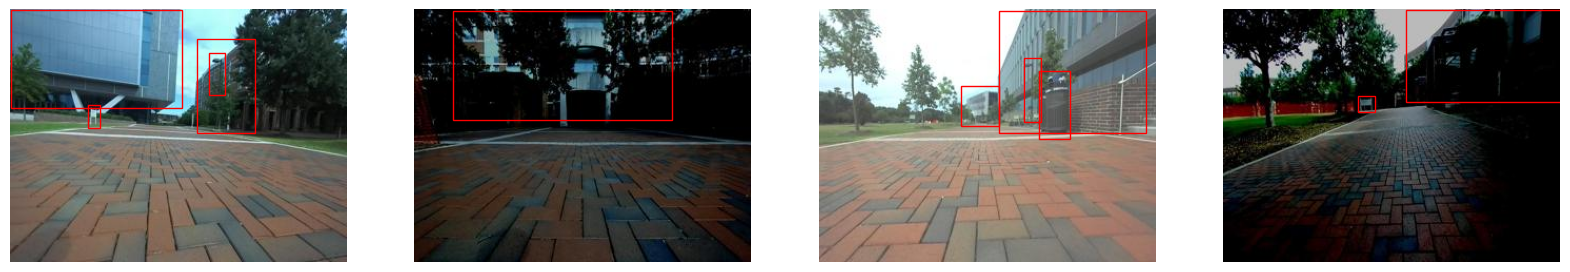

In [5]:
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

In [7]:
# Load a ResNet-18 backbone with FPN (Feature Pyramid Network)
backbone = resnet_fpn_backbone('resnet18', pretrained=True)

# Initialize the Faster R-CNN model with the ResNet-18 backbone
model = torchvision.models.detection.FasterRCNN(backbone, num_classes=91)  # Default COCO classes

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/home/pthapa4/Downloads/yes/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/pthapa4/Downloads/yes/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pthapa4/Downloads/yes/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

In [8]:
# Training Parameters
num_epochs = 6
learning_rate = 0.005
model_save_path = "model_resnet18.pt"

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Iteration: {i}, Loss: {losses.item():.4f}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")
    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f"model_resnet18_epoch_{epoch + 1}.pth")
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")

# Save the final model
torch.save(model.state_dict(), model_save_path)
print("Training complete. Model saved as model_resnet18.pt")

Starting epoch 1/6
Epoch: 1/6, Iteration: 0, Loss: 3.2148
Epoch: 1/6, Iteration: 10, Loss: 0.7512
Epoch: 1/6, Iteration: 20, Loss: 0.5789
Epoch: 1/6, Iteration: 30, Loss: 0.5636
Epoch: 1/6, Iteration: 40, Loss: 0.4591
Epoch: 1/6, Iteration: 50, Loss: 0.4395
Epoch: 1/6, Iteration: 60, Loss: 0.5192
Epoch: 1/6, Iteration: 70, Loss: 0.3583
Epoch: 1/6, Iteration: 80, Loss: 0.5125
Epoch: 1/6, Iteration: 90, Loss: 0.4220
Epoch: 1/6, Iteration: 100, Loss: 0.9820
Epoch: 1/6, Iteration: 110, Loss: 0.4293
Epoch: 1/6, Iteration: 120, Loss: 0.4449
Epoch: 1/6, Iteration: 130, Loss: 0.5901
Epoch: 1/6, Iteration: 140, Loss: 0.3294
Epoch: 1/6, Iteration: 150, Loss: 0.4119
Epoch: 1/6, Iteration: 160, Loss: 0.3197
Epoch: 1/6, Iteration: 170, Loss: 0.4040
Epoch: 1/6, Iteration: 180, Loss: 0.8090
Epoch: 1/6, Iteration: 190, Loss: 0.3188
Epoch: 1/6, Iteration: 200, Loss: 0.4325
Epoch: 1/6, Iteration: 210, Loss: 0.5721
Epoch: 1/6, Iteration: 220, Loss: 0.4827
Finished epoch 1/6, Loss: 0.4014
Finished epoch 1

In [10]:
model_save_path = "model_resnet18.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

In [15]:
def compute_iou(box1, box2):
    """Compute the Intersection over Union (IoU) of two bounding boxes."""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = "model_resnet18.pt"

# Load the trained model and move to device
backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model = torchvision.models.detection.FasterRCNN(backbone, num_classes=91)  # Modify num_classes as necessary
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Define transformation for test data
transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load your test dataset
test_coco_json_path = 'university_annotations/test/_annotations.coco.json'
test_image_folder = 'university_annotations/test/test_images'
test_dataset = COCODataset(test_coco_json_path, test_image_folder, transforms=transform_test)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Track metrics for different IoU thresholds
iou_thresholds = np.arange(0.1, 1.0, 0.1)
precision_scores = []
recall_scores = []
f1_scores = []

for iou_threshold in iou_thresholds:
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            # Post-process outputs to match predictions with true labels
            for output, target in zip(outputs, targets):
                pred_labels = output['labels'].cpu().numpy()
                pred_boxes = output['boxes'].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                true_boxes = target['boxes'].cpu().numpy()

                matched_pred_labels = []
                matched_true_labels = []

                for true_box, true_label in zip(true_boxes, true_labels):
                    best_iou = 0
                    best_pred_idx = -1

                    for pred_idx, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
                        iou = compute_iou(true_box, pred_box)

                        if iou > best_iou:
                            best_iou = iou
                            best_pred_idx = pred_idx

                    if best_pred_idx != -1 and best_iou > iou_threshold:
                        matched_pred_labels.append(pred_labels[best_pred_idx])
                        matched_true_labels.append(true_label)

                all_predictions.extend(matched_pred_labels)
                all_true_labels.extend(matched_true_labels)

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)

    if len(all_predictions) == 0 or len(all_true_labels) == 0:
        precision, recall, f1 = 0, 0, 0
    else:
        # Calculate metrics
        precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, precision_scores, label='Precision', marker='o')
plt.plot(iou_thresholds, recall_scores, label='Recall', marker='o')
plt.plot(iou_thresholds, f1_scores, label='F1 Score', marker='o')

plt.xlabel('IoU Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. IoU Threshold')
plt.legend()
plt.grid(True)
plt.show()

ValueError: backbone should contain an attribute out_channels specifying the number of output channels (assumed to be the same for all the levels)

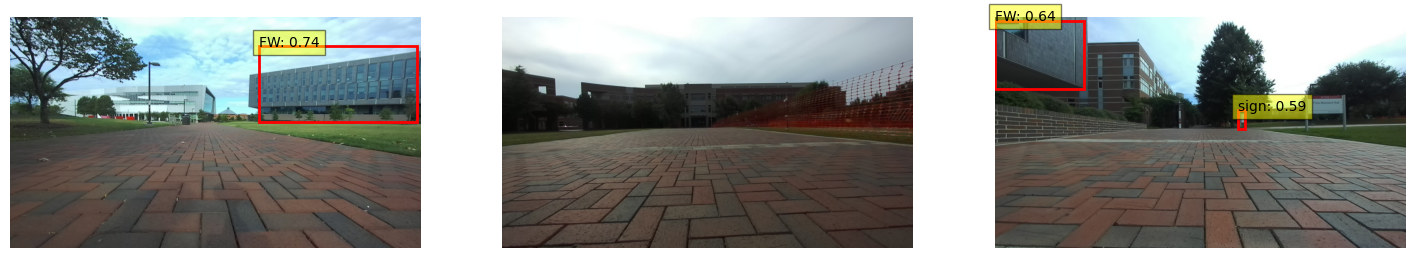

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define categories as per the COCO dataset
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "FW"},
    {"id": 2, "name": "HUNT"},
    {"id": 3, "name": "OVAL"},
    {"id": 4, "name": "engineering-building"},
    {"id": 5, "name": "security-station"},
    {"id": 6, "name": "sign"},
    {"id": 7, "name": "street-lamp"},
    {"id": 8, "name": "trashcan"}
]

model_save_path = "model_resnet18_epoch_6.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),  
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0) 

# Load and preprocess the test images
test_image_path1 = 'test_image1.jpg'
test_image_path2 = 'test_image2.jpg'
test_image_path3 = 'test_image3.jpg'
test_image1 = load_image(test_image_path1).to(device)
test_image2 = load_image(test_image_path2).to(device)
test_image3 = load_image(test_image_path3).to(device)

# Ensure the model is on the correct device
model = model.to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    prediction1 = model(test_image1)
    prediction2 = model(test_image2)
    prediction3 = model(test_image3)

# Create a dictionary to map label IDs to category names
label_to_category = {cat['id']: cat['name'] for cat in categories}

def visualize_predictions(images, predictions, threshold=0.5):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for ax, image, prediction in zip(axs, images, predictions):
        # Convert the tensor image to a NumPy array and transpose the dimensions
        image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)

        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        # Create a list of (score, label, box) tuples and sort by score descending
        predictions = sorted(zip(scores, labels, boxes), key=lambda x: x[0], reverse=True)

        # Keep track of the count of predictions per label type
        label_counts = {}

        for score, label, box in predictions:
            if score >= threshold:
                if label not in label_counts:
                    label_counts[label] = 0
                if label_counts[label] < 2:
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(xmin, ymin, f'{label_to_category.get(label, "Unknown")}: {score:.2f}', 
                            bbox=dict(facecolor='yellow', alpha=0.5))
                    label_counts[label] += 1

        ax.axis('off')

    plt.show()

# Visualize predictions for all three images
visualize_predictions([test_image1, test_image2, test_image3], [prediction1, prediction2, prediction3])